In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 22 04:06:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("./gdrive/MyDrive/ML DL datasets"))


['fakeimage_detection_2.zip', 'deep_fake_detec1', 'deep_fake_detec2', 'deep_fake_detec3', 'fakeimage_detection_3.zip', 'fake_image_detection_4.zip']


In [ ]:
# unzp archive
!unzip "./gdrive/MyDrive/ML DL datasets/fake_image_detection_4.zip"

In [ ]:
training_path = './fake_image_detection_4/train'
test_path = './fake_image_detection_4/test'
validation_path = './fake_image_detection_4/validation'
!ls

fake_image_detection_4	gdrive	__MACOSX  sample_data


In [ ]:
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SeparableConv2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print(tf. __version__) 

2.7.0


In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# import keras
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                  #  rotation_range = 10,
                                  #  width_shift_range = 0.1,
                                  #  height_shift_range = 0.1,
                                   horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
batch_size = 64
input_size=128
training_set = train_datagen.flow_from_directory(training_path,
                                                 target_size = (input_size, input_size),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 107190 images belonging to 2 classes.


In [ ]:
validation_set = valid_datagen.flow_from_directory(validation_path,
                                                 target_size = (input_size, input_size),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 6699 images belonging to 2 classes.


In [ ]:
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=2, baseline=0.801, min_delta=0.001)
checkpoint_filepath = '/content/gdrive/MyDrive/dl_models/checkpoint'
custom_callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        mode = 'min',
        patience = 5,
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_filepath, 'best_base_model.h5'),
        monitor = 'val_loss',
        mode = 'min',
        verbose = 1,
        save_best_only = True
    )
]

In [ ]:
# # Baseline model
classifier = Sequential()
classifier.add(Conv2D(3, (3, 3), input_shape = (input_size, input_size, 3)))
classifier.add(Conv2D(24, (3, 3)))
classifier.add(Conv2D(64, (3, 3)))

classifier.summary()
classifier.add(Flatten())

classifier.add(Dense(units = 300))
classifier.add(Dense(units = 128))
classifier.add(Dense(units = 2, activation = 'softmax'))
classifier.compile(optimizer = optimizers.Adam(learning_rate=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_3 (Separab  (None, 126, 126, 3)      39        
 leConv2D)                                                       
                                                                 
 separable_conv2d_4 (Separab  (None, 124, 124, 24)     123       
 leConv2D)                                                       
                                                                 
 separable_conv2d_5 (Separab  (None, 122, 122, 64)     1816      
 leConv2D)                                                       
                                                                 
Total params: 1,978
Trainable params: 1,978
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 1693 or 3386
history = classifier.fit(
                        training_set,
                        steps_per_epoch=len(training_set),
                        epochs=10,
                        verbose=1,
                        validation_data=validation_set,
                        callbacks = custom_callbacks
                         )

Epoch 1/10
1675/1675 [==============================] - ETA: 0s - loss: 1.2143 - accuracy: 0.8487
Epoch 00001: val_loss improved from inf to 0.34854, saving model to /content/gdrive/MyDrive/dl_models/checkpoint/best_base_model.h5
1675/1675 [==============================] - 1077s 633ms/step - loss: 1.2143 - accuracy: 0.8487 - val_loss: 0.3485 - val_accuracy: 0.8668
Epoch 2/10
1675/1675 [==============================] - ETA: 0s - loss: 0.3524 - accuracy: 0.8629
Epoch 00002: val_loss did not improve from 0.34854
1675/1675 [==============================] - 1064s 635ms/step - loss: 0.3524 - accuracy: 0.8629 - val_loss: 0.3627 - val_accuracy: 0.8400
Epoch 3/10
1675/1675 [==============================] - ETA: 0s - loss: 0.3604 - accuracy: 0.8586
Epoch 00003: val_loss improved from 0.34854 to 0.34564, saving model to /content/gdrive/MyDrive/dl_models/checkpoint/best_base_model.h5
1675/1675 [==============================] - 1028s 613ms/step - loss: 0.3604 - accuracy: 0.8586 - val_loss: 0.3

In [ ]:
save_path = '/content/gdrive/MyDrive/dl_models/'
model_name = 'categorical_fake_image_classifierEfB80.h5'
classifier.save(save_path + model_name)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
!ls  /content/gdrive/MyDrive/dl_models

fake_image_classifierEfB80.h5


In [21]:
from keras.models import load_model
best_model = '/content/gdrive/MyDrive/dl_models/checkpoint/best_base_model.h5'
model = load_model(best_model)
# classifier = model

**Prediction section**

In [22]:
def predict_images(folder, image_name):
    #Making Single new prediction
    import numpy as np
    #from keras.preprocessing.image import image
    import keras.preprocessing.image as image
    test_image = image.load_img(f'./fake_image_detection_4/test/{folder}/{image_name}', target_size = (input_size, input_size))
    test_image = image.img_to_array(test_image)
    test_image = test_image /255.
    #use this function to change the image from 2dimension(64, 64) to 3dimension(64, 64, 3)
    test_image = np.expand_dims(test_image, axis=0)
    #add one more dimension before predicting because the predict method expects a batch
    images = np.vstack([test_image])
    result = model.predict(images, batch_size=10)

    prediction = ''
    if np.argmax(result) == 0:
      prediction = 'fake'
    elif np.argmax(result) == 1:
      prediction = 'real'
    return prediction

In [23]:

import os
fake_images = os.listdir("./fake_image_detection_4/test/fake")
real_images = os.listdir("./fake_image_detection_4/test/real")

res_fake = []
res_real = []

for image_name in fake_images:
    res_fake.append(predict_images('fake', image_name))
for image_name in real_images:
    res_real.append(predict_images('real', image_name))

In [24]:
from collections import Counter
results = (Counter(res_fake), Counter(res_real))
results

(Counter({'fake': 10001, 'real': 48}), Counter({'fake': 2530, 'real': 7519}))

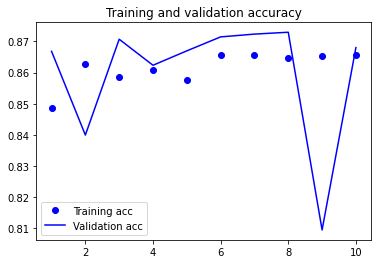

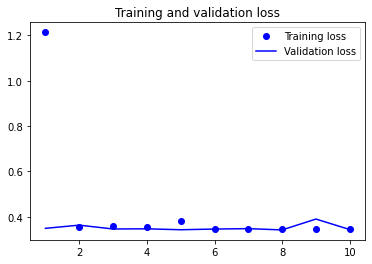

In [29]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()